# **Chiper MLOps Challenge**
**Job Position:** Machine Learning Engineer.<br>
**Applicant:** Isail Salazar Acosta, Colombia.<br><br>
<hr>

## **Introduction**
The challenge consists of applying some steps of machine learning engineering to the sample dataset TICKIT for deploying a forecasting model.

The TICKIT dataset helps analysts track sales activity for the fictional TICKIT web site, where users buy and sell tickets online for sporting events, shows, and concerts. In particular, analysts can identify ticket movement over time, success rates for sellers, and the best-selling events, venues, and seasons. Analysts can use this information to provide incentives to buyers and sellers who frequent the site, to attract new users, and to drive advertising and promotions.

In [1]:
import pandas as pd
#%% Definitions
def load_data(file, delimiter, columns):
    with open(file,'r') as f:
        records = list(map(lambda s:s.rstrip('\n').split(delimiter),f.readlines()))    
    df_data = pd.DataFrame(records, columns=columns)
    return df_data

In [2]:
#%% Loading Dataset
#-- FACT TABLES ---------------------------------------------------------------
df_sales = load_data(file='tickitdb/sales_tab.txt', 
                     delimiter='\t',
                     columns=['salesid', 
                        	'listid',
                        	'sellerid',
                        	'buyerid', 
                        	'eventid', 
                        	'dateid', 
                        	'qtysold',
                        	'pricepaid', 
                        	'commission',
                        	'saletime'])
df_listings = load_data(file='tickitdb/listings_pipe.txt', 
                     delimiter='|',
                     columns=['listid',
                        	'sellerid',
                        	'eventid',
                        	'dateid',
                        	'numtickets',
                        	'priceperticket',
                        	'totalprice',
                        	'listtime'])
#-- DIMENSION TABLES ----------------------------------------------------------
df_events = load_data(file='tickitdb/allevents_pipe.txt', 
                     delimiter='|',
                     columns=['eventid',
                             	'venueid',
                             	'catid',
                             	'dateid',
                             	'eventname',
                             	'starttime'])
df_dates = load_data(file='tickitdb/date2008_pipe.txt', 
                     delimiter='|',
                     columns=['dateid',
                        	'caldate',
                        	'day',
                        	'week',
                        	'month',
                        	'qtr',
                        	'year',
                        	'holiday'])
df_venues = load_data(file='tickitdb/venue_pipe.txt', 
                     delimiter='|',
                     columns=['venueid',
                        	'venuename',
                        	'venuecity',
                        	'venuestate',
                        	'venueseats'])
df_categories = load_data(file='tickitdb/category_pipe.txt', 
                     delimiter='|',
                     columns=['catid',
                        	'catgroup',
                        	'catname',
                        	'catdesc'])
df_users = load_data(file='tickitdb/allusers_pipe.txt', 
                     delimiter='|',
                     columns=['userid',
                        	'username',
                        	'firstname',
                        	'lastname',
                        	'city',
                        	'state',
                        	'email',
                        	'phone',
                        	'likesports',
                        	'liketheatre',
                        	'likeconcerts',
                        	'likejazz',
                        	'likeclassical',
                        	'likeopera',
                        	'likerock',
                        	'likevegas',
                        	'likebroadway',
                        	'likemusicals'])

## **Data Formatting**
We need to assign proper formatting for the date columns of the loaded dataframes, as well as for some other important columns with number types.

In [3]:
# Sales table format conversion
df_sales['saletime'] = pd.to_datetime(df_sales['saletime'], format='%m/%d/%Y %H:%M:%S').dt.date
df_sales['eventid'] = df_sales['eventid'].astype('Int64')
df_sales['qtysold'] = df_sales['qtysold'].astype('Int16')
df_sales['pricepaid'] = df_sales['pricepaid'].astype('float')
# Ordering 
df_sales = df_sales.sort_values(by=['saletime','eventid'])
# Printing
df_sales

salesid  listid sellerid buyerid  eventid dateid  qtysold  pricepaid  \
65083    65082   73790    20429     451     1150   1827        4      472.0   
110919  110917  127048    37631     116     1749   1827        1      337.0   
33094    33095   36572    30047     660     2903   1827        2      234.0   
110330  110328  126347     6955     394     6213   1827        1      347.0   
157755  157751  206999     3003     157     6605   1827        1     1730.0   
...        ...     ...      ...     ...      ...    ...      ...        ...   
45192             None     None    None     <NA>   None     <NA>        NaN   
100394            None     None    None     <NA>   None     <NA>        NaN   
140797            None     None    None     <NA>   None     <NA>        NaN   
144742            None     None    None     <NA>   None     <NA>        NaN   
166197            None     None    None     <NA>   None     <NA>        NaN   

       commission    saletime  
65083        70.8  2008-01-01  
110919      50.55  2008-01-01  
33094        35.1  2008-01-01  
110330      52.05  2008-01-01  
157755      259.5  2008-01-01  
...           ...         ...  
45192        None         NaN  
100394       None         NaN  
140797       None         NaN  
144742       None         NaN  
166197       None         NaN  

[172462 rows x 10 columns]

In [4]:
# Listings table format conversion
df_listings['listtime'] = pd.to_datetime(df_listings['listtime'], format='%Y-%m-%d %H:%M:%S').dt.date
df_listings['eventid'] = df_listings['eventid'].astype('Int64')
df_listings['numtickets'] = df_listings['numtickets'].astype('Int16')
df_listings['totalprice'] = df_listings['totalprice'].astype('float')
df_listings= df_listings.merge(df_dates[['dateid','week']], on='dateid')
# Ordering
df_listings = df_listings.sort_values(by=['listtime', 'eventid'])
# Printing
df_listings

listid sellerid  eventid dateid  numtickets priceperticket  \
133919   63743     3029       31   1827          18         175.00   
134329  227210    16709       50   1827           7        1052.00   
134309  221130    14090       56   1827           1        1080.00   
134041  101781     1090       59   1827          12         183.00   
134146  135369    12722       89   1827          22         263.00   
...        ...      ...      ...    ...         ...            ...   
192496  158678    15589     3305   2191           4         442.00   
192490   55967    36546     5099   2191          10         231.00   
192493   90258    47338     6783   2191          14         382.00   
192488   34734     2720     7192   2191           8         286.00   
192492   70764    49625     8372   2191           3         411.00   

        totalprice    listtime week  
133919      3150.0  2008-01-01    1  
134329      7364.0  2008-01-01    1  
134309      1080.0  2008-01-01    1  
134041      2196.0  2008-01-01    1  
134146      5786.0  2008-01-01    1  
...            ...         ...  ...  
192496      1768.0  2008-12-31   53  
192490      2310.0  2008-12-31   53  
192493      5348.0  2008-12-31   53  
192488      2288.0  2008-12-31   53  
192492      1233.0  2008-12-31   53  

[192497 rows x 9 columns]

In [5]:
# Events table format conversion
df_events['starttime'] = pd.to_datetime(df_events['starttime'], format='%Y-%m-%d %H:%M:%S').dt.date
df_events['eventid'] = df_events['eventid'].astype('Int64')
# Ordering
df_events = df_events.sort_values(by=['starttime', 'eventid'])
print('Total number of Events held:', len(pd.unique(df_events['eventid'])))
print('Total number of unique Events:', len(pd.unique(df_events['eventname'])))
df_events

Total number of Events held: 8798
Total number of unique Events: 576


eventid venueid catid dateid              eventname   starttime
422       423     303     8   1827  La Damnation de Faust  2008-01-01
1216     1217     238     6   1827             Mamma Mia!  2008-01-01
1333     1334     208     6   1827         The King and I  2008-01-01
1375     1376     235     6   1827         The King and I  2008-01-01
1432     1433     248     6   1827                 Grease  2008-01-01
...       ...     ...   ...    ...                    ...         ...
7191     7192      54     9   2191     Lindsey Buckingham  2008-12-31
7603     7604      28     9   2191          Patty Griffin  2008-12-31
8026     8027     130     9   2191         Emmylou Harris  2008-12-31
8167     8168      70     9   2191      Little River Band  2008-12-31
8371     8372      42     9   2191                Toadies  2008-12-31

[8798 rows x 6 columns]

## **Plotting Sales**
The task is to forecast daily sales. We need to aggregate the sales data at the daily level and sum up the number of tickets that were sold and the total price paid for the tickets.

<AxesSubplot:title={'center':'Daily Events with Sales Activity'}, xlabel='saletime'>

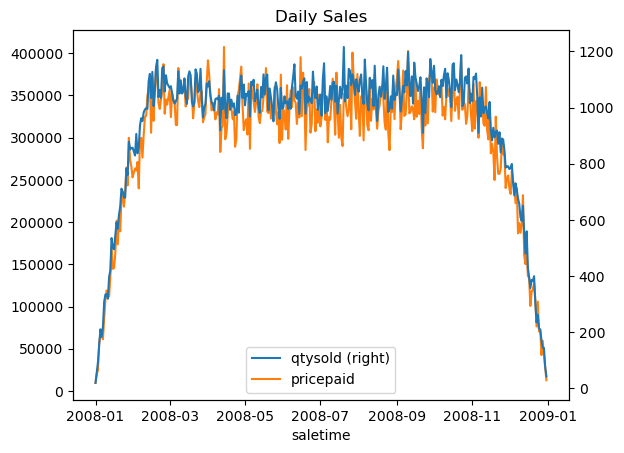

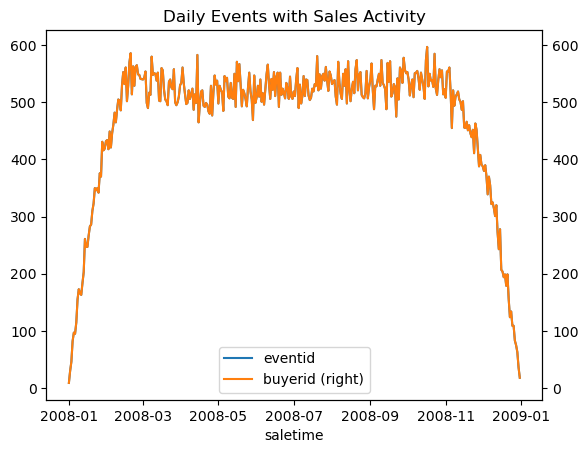

In [6]:
df_sales_daily = df_sales.groupby('saletime').aggregate({'qtysold': 'sum', 
                                                         'pricepaid': 'sum',
                                                         'eventid': 'count',
                                                         'buyerid': 'count'})
df_sales_daily.head(10)
df_sales_daily[['qtysold','pricepaid']].plot(secondary_y='qtysold', title='Daily Sales')
df_sales_daily[['eventid','buyerid']].plot(secondary_y='buyerid', title='Daily Events with Sales Activity')

We then proceed to compare the above trend with the availability of events and tickets to determine if this influences the evidenced pattern of sales.

<AxesSubplot:title={'center':'Daily Events Available for Sales'}, xlabel='listtime'>

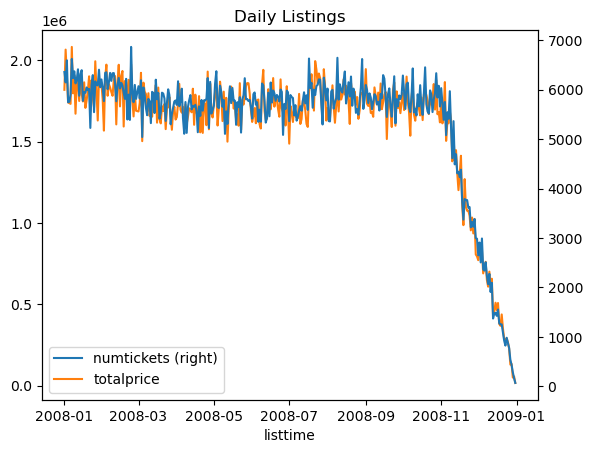

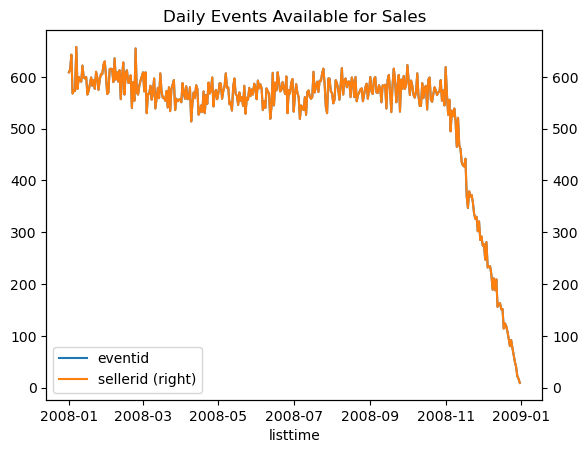

In [7]:
df_listings_daily = df_listings.groupby('listtime').aggregate({'numtickets': 'sum', 
                                                               'totalprice': 'sum',
                                                               'eventid': 'count',
                                                               'sellerid': 'count'})
df_listings_daily.head(10)
df_listings_daily[['numtickets','totalprice']].plot(secondary_y='numtickets', title='Daily Listings')
df_listings_daily[['eventid','sellerid']].plot(secondary_y='sellerid', title='Daily Events Available for Sales')

Although there are plenty of events available in the first weeks of the year, there is no significant sales activity until after the second month. This confirms that the sales vary with the saletime feature and there is a seasonality factor present in our data.

## **Forecasting Model**
We can state a yearly seasonality on our data with an incrementing sales trend at the beggining of the year, followed by a stable average behavior over most of the year. Subsequently, sales activity tends to decrease to 0 towards the end of the year. 

Given these considerations, we can propose the use of the Prophet model, which is open-source tool by Facebook. This model is used for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality.

The input to Prophet is always a dataframe with two columns: **ds** (datestamp of the saletime) and **y** (output daily sales in price units)

In [9]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

# Training dataset for the prophet model (whole year 2008)
train_prophet = df_sales_daily[['pricepaid']].reset_index().\
                    rename(columns={'saletime':'ds', 'pricepaid':'y'}) 
train_prophet.head(10)

ds         y
0  2008-01-01    9544.0
1  2008-01-02   19968.0
2  2008-01-03   24851.0
3  2008-01-04   57262.0
4  2008-01-05   68062.0
5  2008-01-06   65304.0
6  2008-01-07   61174.0
7  2008-01-08   86017.0
8  2008-01-09  107367.0
9  2008-01-10  119050.0

In [10]:
# Model fitting with yearly seasonality 
model = Prophet(yearly_seasonality=True)
model.fit(train_prophet)

22:39:36 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing


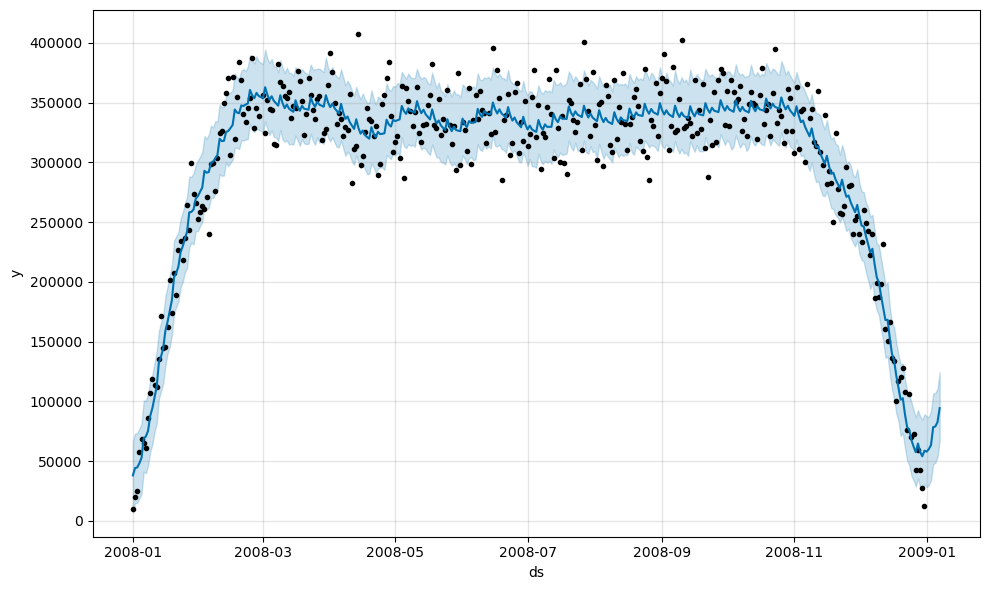

In [12]:
# Computing predictions by specifying a period of 7 Days
df_future = model.make_future_dataframe(periods=7, freq='D')
forecast_prophet = model.predict(df_future)

model.plot(forecast_prophet);

C:\Users\isail\AppData\Local\Temp\ipykernel_13644\2620822053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_future['year'] = df_sales_future['ds'].dt.year


<AxesSubplot:title={'center':'Predicting Daily Sales (Total Price)'}, xlabel='ds'>

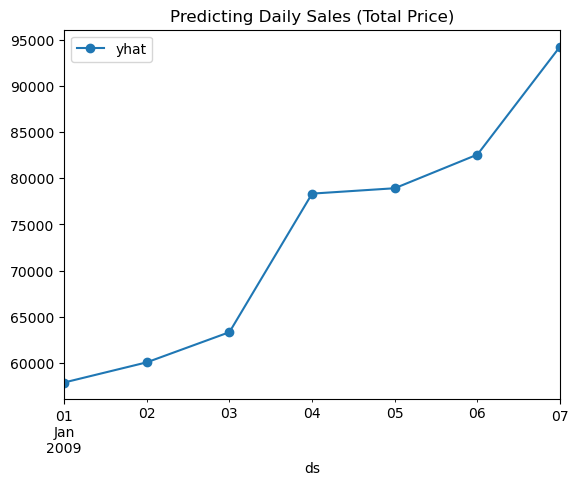

In [19]:
# Plotting individual 7-day prediction
df_sales_future = forecast_prophet[['ds','yhat']]
df_sales_future['year'] = df_sales_future['ds'].dt.year
df_sales_future = df_sales_future.query('year == 2009')
df_sales_future[['ds','yhat']].plot(x='ds', y='yhat', marker='o', title='Predicting Daily Sales (Total Price)')

In [14]:
# Saving 7-day output in json format
df_sales_future['date'] = df_sales_future['ds'].dt.strftime('%Y-%m-%d')
df_sales_future['yhat'] = df_sales_future['yhat'].astype('int')
df_sales_future[['date','yhat']].to_json(r'output.json', orient='index')

In [15]:
# Saving trained model in json format
with open('model.json', 'w') as fout:
    fout.write(model_to_json(model)) 

In [17]:
# Check json output
print(df_sales_future[['date','yhat']].to_json(orient='index'))

{"365":{"date":"2009-01-01","yhat":57854},"366":{"date":"2009-01-02","yhat":60043},"367":{"date":"2009-01-03","yhat":63317},"368":{"date":"2009-01-04","yhat":78344},"369":{"date":"2009-01-05","yhat":78928},"370":{"date":"2009-01-06","yhat":82580},"371":{"date":"2009-01-07","yhat":94300}}


Taking into account the trained model that was saved as a json file, and the integer (7) and string format ('D') inputs for the specification of the days to be predicted, we proceed to implement the REST API code using the FastAPI library. Once the local demo of the FastAPI deployment is completed (by using Uvicorn), we proceed to dockerize the model together with the FastAPI implementation in the same docker container. Finally, the dockerized project is deployed on the AWS cloud, using an EC2 instance by configuring the endpoint http://3.134.101.35:9993/predict which accepts the POST method and allows sales price forecasting for the defined inputs. 

In the following link you can validate the documentation of the implemented REST API:

# http://3.134.101.35:9993/docs